In [1]:
import sys
import os
import shutil
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt;
# for this course we use locally stored version of pyemu and flopy to avoid version conflicts
import pyemu
import flopy

sys.path.insert(0,"..")
import herebedragons as hbd

### Create temp directory so we don't break anything

In [2]:
# folder containing original model files
org_d = os.path.join('..', 'input-files')

# a dir to hold a copy of the org model files
tmp_d = os.path.join('..','peterson_mf6')

if os.path.exists(tmp_d):
    shutil.rmtree(tmp_d)
shutil.copytree(org_d,tmp_d)

# get executables
hbd.prep_bins(tmp_d)
# get dependency folders
#hbd.prep_deps(tmp_d)

In [3]:
# load simulation
sim = flopy.mf6.MFSimulation.load(sim_ws=tmp_d)
# load flow model
gwf = sim.get_model('peterson_flow')

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package riv...
    loading package obs...
    loading package wel...
    loading package chd...
    loading package sto...
    loading package rch...
    loading package oc...
  loading solution package peterson_flow...


### Spatial Reference

Now we can instantiate a SpatialReference. This will later be passed to PstFrom to assist with spatially locating parameters (e.g. pilot points and/or cell-by-cell parameters). You can also use the flopy modelgrid class instance that is attached to the simulation, but SpatialReference is cleaner and faster for structured grids...

In [4]:
sr = pyemu.helpers.SpatialReference.from_namfile(
        os.path.join(tmp_d, "peterson_flow.nam"),
        delr=gwf.dis.delr.array, delc=gwf.dis.delc.array)
sr

   could not remove start_datetime


xul:0; yul:19440; rotation:0; proj4_str:None; units:meters; lenuni:2; length_multiplier:1.0

### Instantiate PstFrom

Now we can start to construct the PEST(++) interface by instantiating a PstFrom class instance. There are a few things that we need to specify up front:

the folder in which we currently have model files (e.g. tmp_d). PstFrom will copy all the files from this directory into a new "template" folder.

template folder: this is a folder in which the PEST dataset will be constructed - this folder will hold the model files plus all of the files needed to run PEST(++). This folder/dataset will form the template for subsequent deployment of PEST(++).

longnames: for backwards compatibility with PEST and PEST_HP (i.e. non-PEST++ versions), which have upper limits to parameter/observation names (PEST++ does not). Setting this value to False is only recommended if required.

Whether the model is zero based or not.

(optional) the spatial reference, as previously discussed. This is only required if using pyEMU to define parameter spatial correlation. Alternatively, you can define these yourself or use utilities available in the PEST-suite.

In [5]:
# specify a template directory (i.e. the PstFrom working folder)
template_ws = os.path.join('..','peterson_template')
start_datetime="1-1-1970"
# instantiate PstFrom
pf = pyemu.utils.PstFrom(original_d=tmp_d, # where the model is stored
                            new_d=template_ws, # the PEST template folder
                            remove_existing=True, # ensures a clean start
                            longnames=True, # set False if using PEST/PEST_HP
                            spatial_reference=sr, #the spatial reference we generated earlier
                            zero_based=False, # does the MODEL use zero based indices? For example, MODFLOW does NOT
                            start_datetime=start_datetime, # required when specifying temporal correlation between parameters
                            echo=False) # to stop PstFrom from writting lots of infromation to the notebook; experiment by setting it as True to see the difference; usefull for troubleshooting
     

### Write Instructional file from observations

In [6]:
# Read in output heads and real observed heads
obs_df = pd.read_csv('../input-files/data-files/flow-observed-heads.csv')
heads_df = pd.read_csv('../output-files/head_obs.csv')

In [7]:
# Function to find the closest time in mod for a given time in obs
def find_closest_time(time, mod_times):
    closest_time = min(mod_times, key=lambda x: abs(x - time))
    return closest_time

# Apply the function to the 'time' column in obs
obs_df['time'] = obs_df['time'].apply(lambda x: find_closest_time(x, heads_df['time']))
#obs_df.set_index('time', inplace=True)

In [8]:
heads_df

,time,FOUNTAINNO.1,SC01406518ACDT02-MW006,SC01406518CAAMW1-1,SC01406519ABDT04-MW004,SC01406519BBBT01-MW002,SC01406520CDBMW2-4,SC01406527ACB1,SC01406527DDB1BANNING-LEWISRANCHES,SC01406527DDB2,...,SCO1506602BBBTH-18,SCO1506602BDC,SCO1506602CAA,SCO1506603AAD,SCO1506603BAC,SCO1506604AAA,SCO1506604AABTH-49,SCO1506604ABA2TH-50,SCO1506610BAA,SCO1506611ABCTH-47
0,59.0,1682.098303,1885.606333,1880.843431,1851.760632,1868.323851,1831.917719,1819.619055,1811.987363,1809.929790,...,1775.603283,1767.051875,1765.866974,1769.343153,1761.990816,1764.006217,1762.177350,1762.214846,1749.560136,1749.058038
1,89.0,1682.038937,1885.607462,1880.845530,1851.766210,1868.327172,1831.924693,1819.789125,1812.106144,1810.086798,...,1775.603504,1767.055192,1765.867715,1769.348475,1761.968190,1763.807373,1762.488230,1762.564457,1749.560514,1749.058045
2,274.0,1681.821939,1885.614389,1880.860133,1851.778377,1868.320266,1832.043149,1819.844403,1812.486479,1810.597249,...,1775.337384,1766.979570,1765.850559,1769.205732,1761.678194,1763.431530,1762.410650,1762.513417,1749.561265,1749.057627
3,304.0,1681.784487,1885.608627,1880.841590,1851.702346,1868.263001,1832.049264,1819.847019,1812.535788,1810.666062,...,1775.239771,1766.940636,1765.842361,1769.126188,1761.626067,1763.372353,1762.396133,1762.503528,1749.557897,1749.057384
4,365.0,1681.731497,1885.599838,1880.811107,1851.609271,1868.166974,1832.034046,1819.847330,1812.591824,1810.757966,...,1775.052013,1766.836397,1765.794242,1768.981045,1761.510544,1763.310496,1762.381099,1762.493302,1749.553499,1749.055416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441,18139.0,1681.075420,1885.563702,1880.683665,1850.428772,1867.725578,1830.435928,1819.833388,1812.563261,1810.691205,...,1772.401958,1764.661901,1763.587730,1766.735478,1760.185542,1762.363657,1761.702683,1761.846363,1748.899277,1747.789591
442,18169.0,1681.076395,1885.562367,1880.681462,1850.424837,1867.721183,1830.430526,1819.830468,1812.561444,1810.690141,...,1772.400349,1764.661090,1763.587641,1766.734010,1760.184538,1762.361230,1761.701893,1761.845822,1748.898909,1747.791960
443,18200.0,1681.078941,1885.562253,1880.680358,1850.421209,1867.717863,1830.425039,1819.829935,1812.562081,1810.690739,...,1772.398810,1764.660057,1763.587605,1766.732561,1760.183094,1762.360767,1761.702018,1761.845920,1748.899003,1747.794271
444,18230.0,1681.080466,1885.562196,1880.679929,1850.418910,1867.716525,1830.421451,1819.830047,1812.562655,1810.691599,...,1772.397803,1764.659348,1763.587487,1766.731656,1760.182567,1762.360485,1761.701950,1761.845878,1748.898961,1747.796325


In [9]:
obs_df

,time,FOUNTAINNO.1,SC01406518ACDT02-MW006,SC01406518CAAMW1-1,SC01406519ABDT04-MW004,SC01406519BBBT01-MW002,SC01406520CDBMW2-4,SC01406527ACB1,SC01406527DDB1BANNING-LEWISRANCHES,SC01406527DDB2,...,SCO1506602BBBTH-18,SCO1506602BDC,SCO1506602CAA,SCO1506603AAD,SCO1506603BAC,SCO1506604AAA,SCO1506604AABTH-49,SCO1506604ABA2TH-50,SCO1506610BAA,SCO1506611ABCTH-47
0,59.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,89.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,454.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,639.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,789.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1802.757888,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,18077.0,NaN,NaN,1885.504992,1866.912192,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
163,18139.0,NaN,NaN,1886.068872,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
164,18169.0,NaN,NaN,1885.861608,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
165,18200.0,NaN,NaN,1885.633008,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
filtered_heads_df = heads_df.where(obs_df.notna(), other=-999)
filtered_heads_df = filtered_heads_df[filtered_heads_df['time'] != -999]
filtered_heads_df

,time,FOUNTAINNO.1,SC01406518ACDT02-MW006,SC01406518CAAMW1-1,SC01406519ABDT04-MW004,SC01406519BBBT01-MW002,SC01406520CDBMW2-4,SC01406527ACB1,SC01406527DDB1BANNING-LEWISRANCHES,SC01406527DDB2,...,SCO1506602BBBTH-18,SCO1506602BDC,SCO1506602CAA,SCO1506603AAD,SCO1506603BAC,SCO1506604AAA,SCO1506604AABTH-49,SCO1506604ABA2TH-50,SCO1506610BAA,SCO1506611ABCTH-47
0,59.0,-999.0,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.0,-999.0,-999.000000,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
1,89.0,-999.0,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.0,-999.0,-999.000000,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
2,274.0,-999.0,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.0,-999.0,-999.000000,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
3,304.0,-999.0,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.0,-999.0,-999.000000,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
4,365.0,-999.0,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.0,-999.0,1810.757966,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,9648.0,-999.0,-999.000000,1880.708241,1850.796116,-999.000000,-999.000000,-999.0,-999.0,-999.000000,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
163,9678.0,-999.0,-999.000000,1880.709062,-999.000000,-999.000000,-999.000000,-999.0,-999.0,-999.000000,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
164,9709.0,-999.0,-999.000000,1880.714043,-999.000000,-999.000000,-999.000000,-999.0,-999.0,-999.000000,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
165,9740.0,-999.0,-999.000000,1880.715717,-999.000000,-999.000000,-999.000000,-999.0,-999.0,-999.000000,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0


In [11]:
filtered_heads_df.set_index('time', inplace=True)

In [12]:
heads_df.set_index('time')
obs_df.set_index('time', inplace=True)

In [13]:
# **Reshape obs_df into long format**
obs_long = filtered_heads_df.stack().reset_index()
obs_long.columns = ["time", "well", "value"]  # "value" column holds observed heads
obs_long

,time,well,value
0,59.0,FOUNTAINNO.1,-999.0
1,59.0,SC01406518ACDT02-MW006,-999.0
2,59.0,SC01406518CAAMW1-1,-999.0
3,59.0,SC01406519ABDT04-MW004,-999.0
4,59.0,SC01406519BBBT01-MW002,-999.0
...,...,...,...
24878,9770.0,SCO1506604AAA,-999.0
24879,9770.0,SCO1506604AABTH-49,-999.0
24880,9770.0,SCO1506604ABA2TH-50,-999.0
24881,9770.0,SCO1506610BAA,-999.0


In [14]:
ins_lines = ["pif ~", "l1"]  # PEST instruction file header, adding "l1" on the second line

# **Group by time and format each time step correctly**
for time, group in obs_long.groupby("time"):
    ins_line = "l1"  # Read one line
    for well, value in zip(group["well"], group["value"]):  
        if value == -999:
            ins_line += f" ~,~ !dum! "
        else:
            ins_line += f" ~,~ !{well}_{time}! "  # Add commas after each observation
    ins_lines.append(ins_line.strip(", "))  # Remove trailing comma after the last well

In [15]:
# Write the .INS file
with open("../peterson_template/head_obs.csv.ins", "w") as f:
    f.write("\n".join(ins_lines))

In [16]:
[f for f in os.listdir(template_ws) if f.endswith(".ins")]

['head_obs.csv.ins']

### Write External INS .csv files to reference in PEST control file

In [17]:
ins_data = {
    'pest_file': ['head_obs.csv.ins'],
    'model_file': ['../output-files/head_obs.csv'],
}
ins_data=pd.DataFrame(ins_data)

In [18]:
ins_data=ins_data.astype(str)
ins_data.to_csv('../peterson_template/peterson.insfile_data.csv', index=False)

### Write External observation .csv files to reference in PEST control file

In [19]:
obs_long = obs_long[obs_long['value'] != -999]

In [20]:
# Initialize an empty list to store the formatted rows for the new DataFrame
obs_data = []

# Group by the 'time' column to match the instruction file format
for time, group in obs_long.groupby("time"):
    for _, row in group.iterrows():
        # Construct a new row for each observation with the desired columns
        new_row = {
            "obsnme": f"{row['well']}_{time}",  # Observation name: well_name_time
            "obsval": row["value"],             # Observation value: the value in the 'value' column
            "weight": 1,                        # Observation weight: always 1
            "obgnme": "hds"                    # Observation group: always 'hds'
        }
        obs_data.append(new_row)

# Create the new DataFrame from the list of formatted rows
obs_data_df = pd.DataFrame(obs_data)
obs_data_df

,obsnme,obsval,weight,obgnme
0,SC01506528DCD2_59.0,1707.636370,1,hds
1,SC01506510ABB2_89.0,1763.762996,1,hds
2,SC01506528DCD1USGS384231104400600_89.0,1708.094291,1,hds
3,SC01606517AAA1_89.0,1666.912900,1,hds
4,SC01506510ABB2_274.0,1762.455662,1,hds
...,...,...,...,...
2742,SC01506612CDCCO259-25_9770.0,1737.119058,1,hds
2743,SC01506613CBD1U-14B_9770.0,1724.333110,1,hds
2744,SC01506613DDC1U-15_9770.0,1723.986383,1,hds
2745,SC01506614BBATH-5_9770.0,1737.032394,1,hds


In [21]:
obs_data_df=obs_data_df.astype(str)
obs_data_df.to_csv('../peterson_template/peterson.obs_data.csv', index=False)

### Write the template file

In [22]:
# get the IIDOMAIN array; in our case we only have one layer
ib = gwf.dis.idomain.array[0]

Unique values: [0. 1. 2. 3. 4. 5.]


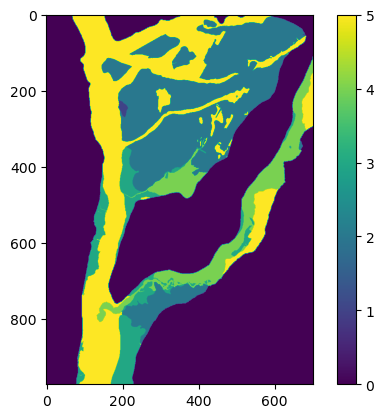

In [23]:
#create the zones matrix
zones_matrix = np.loadtxt(os.path.join('..', 'peterson_template','data-files','rchZones.dat'))
#zones = np.where(np.isin(zones_matrix, [2, 3,4,5]), zones_matrix, 0)
zones= np.where(ib == 1, zones_matrix, 0)
unique_values = np.unique(zones)  # Get unique values
print("Unique values:", unique_values)
plt.imshow(zones)
plt.colorbar()

In [24]:
#save zones matrix
np.savetxt(os.path.join('..', 'peterson_template', 'data-files', 'rch_zones.dat'), zones, fmt='%d', delimiter=' ')

In [25]:
with open('../peterson_template/data-files/rch_zones.dat', 'r') as f:
    values = [line.strip().split() for line in f.readlines()]

# Specify a new file name for the output
template_filename = '../peterson_template/rchMult.dat.tpl'

# Write the PEST++ template to the new file
with open(template_filename, 'w') as tpl:
    tpl.write("ptf ~\n")  # Start the template file with ptf~

    for line in values:
        tpl_line = []
        for val in line:
            # Check if the value is "0" and keep it as "0"
            if val == '0' or val == '0.0' or val.lower() == '0.000000000000000000e+00':
                tpl_line.append('0')
            else:
                try:
                    # If the value is not "0", try to convert it to an integer
                    param_number = int(float(val))  # Convert to float first for scientific notation
                    # Only replace if the value is not zero
                    if param_number != 0:
                        tpl_line.append(f"~rch{param_number}~")
                    else:
                        tpl_line.append('0')
                except ValueError:
                    # If conversion fails, handle the value (e.g., skip it or use a default placeholder)
                    tpl_line.append(f"~rch_invalid~")  # Or another placeholder you prefer
        tpl.write(' '.join(tpl_line) + '\n')

In [26]:
[f for f in os.listdir(template_ws) if f.endswith(".tpl")]

['rchMult.dat.tpl']

### Write External TPL .csv files to reference in PEST control file

In [27]:
tpl_data = {
    'pest_file': ['rchMult.dat.tpl'],
    'model_file': ['rchMult.dat'],
}
tpl_data=pd.DataFrame(tpl_data)

In [28]:
tpl_data=tpl_data.astype(str)
tpl_data.to_csv('../peterson_template/peterson.tplfile_data.csv', index=False)

### Write External Parameter .csv files to reference in PEST control file

##### Function to write Parameter Groups to csv

In [29]:
def build_param_group_df(param_groups, inctyp_vals, derinc_vals, derinclb_vals, forcen_vals, derincmul_vals, dermthd_vals, splitthresh_vals, splitaction_vals, n_vals):
    """
    Build a DataFrame with the same structure for multiple parameter groups.
    
    Parameters:
    - param_groups: List of parameter group names (zones)
    - inctyp_vals, derinc_vals, derinclb_vals, forcen_vals, derincmul_vals, dermthd_vals, splitthresh_vals, splitaction_vals: 
      Lists with values to be repeated for each parameter group
    
    Returns:
    - DataFrame with rows for each parameter group
    """
    data = {
        'pargpnme': [],
        'inctyp': [],
        'derinc': [],
        'derinclb': [],
        'forcen': [],
        'derincmul': [],
        'dermthd': [],
        'splitthresh': [],
        'splitaction': [],
        'n':[]
    }
    
    for group in param_groups:
        for i in range(len(inctyp_vals)):  # Assuming all lists have the same length
            data['pargpnme'].append(group)
            data['inctyp'].append(inctyp_vals[i])
            data['derinc'].append(derinc_vals[i])
            data['derinclb'].append(derinclb_vals[i])
            data['forcen'].append(forcen_vals[i])
            data['derincmul'].append(derincmul_vals[i])
            data['dermthd'].append(dermthd_vals[i])
            data['splitthresh'].append(splitthresh_vals[i])
            data['splitaction'].append(splitaction_vals[i])
            data['n'].append(n_vals[i])
    
    return pd.DataFrame(data)

##### Write recharge Parameter groups csv

In [30]:
param_groups = ['rch']

# Define the values that should be repeated for each group
inctyp_vals = ['relative']  # Example values for 'inctyp'
derinc_vals = [0.01]
derinclb_vals = [0]
forcen_vals = ['switch']
derincmul_vals = [2]
dermthd_vals = ['parabolic']
splitthresh_vals = [0.00001]
splitaction_vals = [0.5]
n_vals= ['smaller']

# Build the DataFrame
pargp_df = build_param_group_df(param_groups, inctyp_vals, derinc_vals, derinclb_vals, forcen_vals, derincmul_vals, dermthd_vals, splitthresh_vals, splitaction_vals,n_vals)

In [31]:
pargp_df

,pargpnme,inctyp,derinc,derinclb,forcen,derincmul,dermthd,splitthresh,splitaction,n
0,rch,relative,0.01,0,switch,2,parabolic,0.00001,0.5,smaller


In [32]:
# Save the DataFrame to a CSV file
output_filename = '../peterson_template/peterson.pargp_data.csv'
pargp_df=pargp_df.astype(str)
pargp_df.to_csv(output_filename, index=False)

In [33]:
def build_param_df(param_names, partrans, parchglim, parval1, parlbnd, parubnd, pargp, scale, offset, dercom):
    """
    Build a DataFrame with customized parameter values and export it to a CSV for PEST++.

    Parameters:
    - param_names: List of parameter names
    - partrans: List of transformation types for each parameter
    - parchglim: List of change limits for each parameter
    - parval1: List of initial values for each parameter
    - parlbnd: List of lower bounds for each parameter
    - parubnd: List of upper bounds for each parameter
    - pargp: List of parameter groups (zones)
    - scale: List of scale factors for each parameter
    - offset: List of offsets for each parameter
    - dercom: List of derivative computation flags for each parameter

    Returns:
    - DataFrame with rows for each parameter group and exported as a CSV file
    """
    
    # Creating the data dictionary for the DataFrame
    data = {
        'parnme': param_names,
        'partrans': partrans,
        'parchglim': parchglim,
        'parval1': parval1,
        'parlbnd': parlbnd,
        'parubnd': parubnd,
        'pargp': pargp,
        'scale': scale,
        'offset': offset,
        'dercom': dercom
    }
    # Creating the DataFrame
    param_df = pd.DataFrame(data)

    # Exporting to CSV for PEST++
    param_df=param_df.astype(str)
    param_df.to_csv('../peterson_template/peterson.par_data.csv', index=False)

    return param_df

In [34]:
param_names = ['rch1', 'rch2', 'rch3', 'rch4', 'rch5']
partrans = ['log', 'log', 'log', 'log', 'log']
parchglim = ['factor', 'factor', 'factor','factor','factor']
parval1 = [1e-5, 0.1, 0.1, 0.1, 0.2]
parlbnd = [1e-6, 1e-6, 1e-6, 1e-6, 1e-6]
parubnd = [0.5, 0.5, 0.5, 0.5, 0.5]
pargp = ['rch', 'rch', 'rch', 'rch', 'rch']
scale = [1, 1, 1, 1, 1]
offset = [0, 0, 0, 0, 0]
dercom = [1, 1, 1, 1, 1]

param_df = build_param_df(param_names, partrans, parchglim, parval1, parlbnd, parubnd, pargp, scale, offset, dercom)
param_df

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
0,rch1,log,factor,1e-05,1e-06,0.5,rch,1,0,1
1,rch2,log,factor,0.1,1e-06,0.5,rch,1,0,1
2,rch3,log,factor,0.1,1e-06,0.5,rch,1,0,1
3,rch4,log,factor,0.1,1e-06,0.5,rch,1,0,1
4,rch5,log,factor,0.2,1e-06,0.5,rch,1,0,1


In [35]:
def write_pest_version2_control_file(file_path, parameter_group_file, parameter_file, observation_file, model_command, input_file, output_file):
    with open(file_path, 'w') as f:
        # Header with version 2
        f.write("pcf version=2\n")

        # Control data section
        f.write("* control data keyword\n")
        f.write("pestmode                                 estimation\n")
        f.write("noptmax                                 0\n")
        f.write("svdmode                                 1\n")
        f.write("maxsing                                  10000000\n")
        f.write("eigthresh                               1e-06\n")
        f.write("eigwrite                                1\n")
        
        # Parameter groups section
        f.write("* parameter groups external\n")
        f.write(f"{parameter_group_file}\n")

        # Parameter data section
        f.write("* parameter data external\n")
        f.write(f"{parameter_file}\n")

        # Observation data section
        f.write("* observation data external\n")
        f.write(f"{observation_file}\n")

        # Model command line
        f.write("* model command line\n")
        f.write(f"{model_command}\n")

        # Model input file section
        f.write("* model input external\n")
        f.write(f"{input_file}\n")

        # Model output file section
        f.write("* model output external\n")
        f.write(f"{output_file}\n")

In [36]:
# Example usage
write_pest_version2_control_file(
    "../peterson_template/peterson.pst",
    "peterson.pargp_data.csv",
    "peterson.par_data.csv",
    "peterson.obs_data.csv",
    "python forward_run.py",
    "peterson.tplfile_data.csv",
    "peterson.insfile_data.csv"
)

In [37]:
shutil.copy('forward_run.py', template_ws)

'..\\peterson_template\\forward_run.py'

In [38]:
import subprocess

In [39]:
# Define the path to your PEST++ executable
pest_exe = "pestpp-glm"

# Define the path to your control file
control_file = "peterson.pst"

# Define the working directory where PEST++ should run
working_dir = template_ws

# Run PEST++ GLM with subprocess, setting the working directory
subprocess.run([pest_exe, control_file], cwd=working_dir, check=True)

CalledProcessError: Command '['pestpp-glm', 'peterson.pst']' returned non-zero exit status 1.

In [34]:
pst = pyemu.Pst('../peterson_template/peterson.pst')

In [36]:
pst.control_data.noptmax

0

In [37]:
pyemu.os_utils.run('pestpp-glm peterson_mf6.pst', cwd=template_ws)

pestpp-glm.exe peterson_mf6.pst


Exception: run() returned non-zero: 1

### The Forward Run Script

In [40]:
# Define file paths
head_obs_file = '../output-files/head_obs.csv'   # Model output head file
real_value_file = '../output-files/real_heads.csv'  # "Real" values file
output_head_file = '../output-files/heads.csv'  # New filtered head output file

# Step 1: Read model output and "real" values
head_obs_df = pd.read_csv(head_obs_file)
real_value_df = pd.read_csv(real_value_file)
# Function to find the closest time in mod for a given time in obs
def find_closest_time(time, mod_times):
    closest_time = min(mod_times, key=lambda x: abs(x - time))
    return closest_time

# Apply the function to the 'time' column in obs
real_value_df['time'] = real_value_df['time'].apply(lambda x: find_closest_time(x, heads_df['time']))

In [41]:
# Function to find the closest time in mod for a given time in obs
def find_closest_time(time, mod_times):
    closest_time = min(mod_times, key=lambda x: abs(x - time))
    return closest_time

# Apply the function to the 'time' column in obs
real_value_df['time'] = real_value_df['time'].apply(lambda x: find_closest_time(x, heads_df['time']))

In [42]:
filtered_heads_df = head_obs_df.where(real_value_df.notna(), other=pd.NA)
filtered_heads_df.to_csv(output_head_file, index=False)

In [43]:
filtered_heads_df.to_csv(output_head_file, index=False)

In [85]:
# Step 2: Remove previous model output files to avoid conflicts
model_output_files = ['model_output_file1', 'model_output_file2']  # Add your specific model output files
for file in model_output_files:
    if os.path.exists(file):
        os.remove(file)
        print(f'Removed {file}')

In [ ]:
# Step 3: Execute the simulator (MODFLOW)
# You can use subprocess to call the MODFLOW executable
modflow_command = 'mf6.exe'  # Adjust to your MODFLOW executable and command
try:
    subprocess.run(modflow_command, check=True)
    print("MODFLOW simulation executed successfully.")
except subprocess.CalledProcessError as e:
    print(f"Error during MODFLOW execution: {e}")

In [ ]:
[f for f in os.listdir(template_ws) if f.endswith(".py") or f.endswith(".pst") ]

In [ ]:
_ = [print(line.rstrip()) for line in open(os.path.join(template_ws,"forward_run.py"))]

### Sys Commands

In [ ]:
pf.mod_sys_cmds 

In [ ]:
pf.mod_sys_cmds.append("mf6") #do this only once
pf.mod_sys_cmds

In [ ]:
pst = pf.build_pst()

_ = [print(line.rstrip()) for line in open(os.path.join(template_ws,"forward_run.py"))]

In [ ]:
# pf.add_py_function("helpers.py","extract_hds_arrays_and_list_dfs()",is_pre_cmd=False)

In [ ]:
# import helpers

In [ ]:
# helpers.test_extract_hds_arrays(template_ws)

In [ ]:
# files = [f for f in os.listdir(template_ws) if f.startswith("hdslay")]

In [ ]:
# for f in files:
#     pf.add_observations(f,prefix=f.split(".")[0],obsgp=f.split(".")[0])

In [ ]:
# for f in ["inc.csv","cum.csv"]:
#     df = pd.read_csv(os.path.join(template_ws,f),index_col=0)
#     pf.add_observations(f,index_cols=["totim"],use_cols=list(df.columns.values),
#                         prefix=f.split('.')[0],obsgp=f.split(".")[0])

In [ ]:
# pst = pf.build_pst()

In [ ]:
_ = [print(line.rstrip()) for line in open(os.path.join(template_ws,"forward_run.py"))]

In [ ]:
obs = pst.observation_data
obs

In [ ]:
pst.write(os.path.join(template_ws, 'peterson_mf6.pst'),version=2)

In [ ]:
pst.control_data.noptmax

In [ ]:
pyemu.os_utils.run('pestpp-glm peterson_mf6.pst', cwd=template_ws)

In [ ]:

# read the file
iobj = pd.read_csv(os.path.join(template_ws, 'peterson_mf6.iobj'))

# check value in phi column
iobj.total_phi
     

### Prior Parameter Covariance Matrix

In [ ]:
# build the prior covariance matrix and store it as a compresed bianry file (otherwise it can get huge!)
# depending on your machine, this may take a while...
if pf.pst.npar < 35000:  #if you have more than about 35K pars, the cov matrix becomes hard to handle
    cov = pf.build_prior(fmt='coo', filename=os.path.join(template_ws,"prior_cov.jcb"))
    # and take a peek at a slice of the matrix
    try: 
        x = cov.x.copy()
        x[x==0] = np.NaN
        plt.imshow(x[:1000,:1000])
    except:
        pass

In [ ]:
cov.row_names[:10]

In [ ]:
#And now generate a prior parameter ensemble. This step is relevant for using pestpp-ies in subsequent tutorials. Note: you do not have to call build_prior() before calling draw()!


pe = pf.draw(num_reals=1000, use_specsim=True) # draw parameters from the prior distribution
pe.enforce() # enforces parameter bounds
pe.to_binary(os.path.join(template_ws,"prior_pe.jcb")) #writes the paramter ensemble to binary file
assert pe.shape[1] == pst.npar

In [ ]:
pst.parameter_data.loc[:,"parval1"] = pe.loc[pe.index[0],pst.par_names].values
pst.parameter_data.parval1.values

In [ ]:
# pst.control_data.noptmax = 0
# pst.write(os.path.join(template_ws,"test.pst"),version=2)
# pyemu.os_utils.run("pestpp-glm test.pst",cwd=template_ws)